In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import math
from LucaM185 import BaseTransformer, train_model, plot_training_history, generate
device = torch.device("cuda:0")
#device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")


In [23]:
with open("datasets/enwik8", "r") as f:
    load = f.read()[:1000000]
print(load[:200])

<mediawiki xmlns="http://www.mediawiki.org/xml/export-0.3/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.mediawiki.org/xml/export-0.3/ http://www.mediawiki.org/


In [24]:
class MyInputs:
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.data) - self.sequence_length
        
    def __getitem__(self, idx):
        start_indices = idx.unsqueeze(1) + torch.arange(self.sequence_length)
        return self.data[start_indices]


In [25]:
# Restricting to ASCII characters
texttoint = {chr(i): i for i in range(256)}
inttotext = {i: chr(i) for i in range(256)}
dataset = torch.tensor([texttoint[c] for c in load if c in texttoint])

vocab_size = len(texttoint)
sequence_length = 20
val_set = int(len(dataset)*0.1)

inputs = MyInputs(dataset[val_set:-1-sequence_length], sequence_length)
labels = MyInputs(dataset[val_set+1:-sequence_length], sequence_length)
val_inputs = MyInputs(dataset[:val_set], sequence_length)
val_labels = MyInputs(dataset[1:val_set+1], sequence_length)

print(len(dataset))

997275


# Baseline

Millions of parameters: 7.23
Epoch ___0 - Loss: 5.946 - Val Loss: 5.521
Epoch _100 - Loss: 2.407 - Val Loss: 2.408
Epoch _200 - Loss: 2.094 - Val Loss: 2.196
Epoch _300 - Loss: 1.933 - Val Loss: 1.933
Epoch _400 - Loss: 1.819 - Val Loss: 1.968
Epoch _500 - Loss: 1.750 - Val Loss: 1.855
Epoch _600 - Loss: 1.660 - Val Loss: 1.720
Epoch _700 - Loss: 1.614 - Val Loss: 1.757
Epoch _800 - Loss: 1.586 - Val Loss: 1.685
Epoch _900 - Loss: 1.522 - Val Loss: 1.733


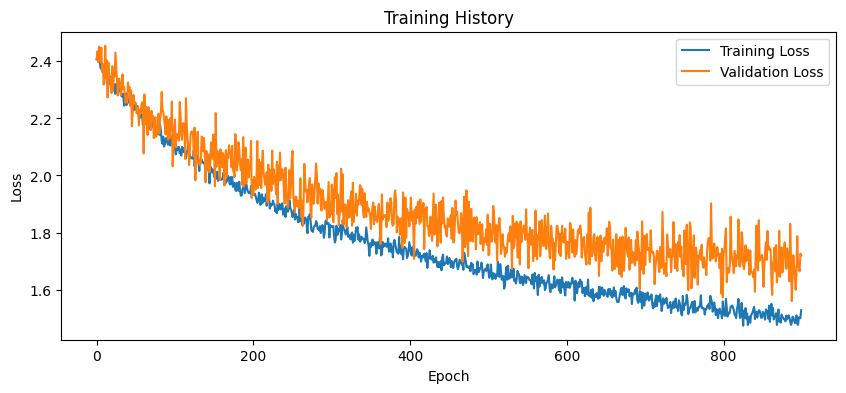

In [26]:

# Create model with default components (uses DefaultAttention and DefaultFullyConnected)
model = BaseTransformer(
    vocab_size=vocab_size,
    emb_size=256,
    sequence_length=sequence_length,
    n_blocks=4
)

# Train it
history = train_model(
    model, inputs, labels, val_inputs, val_labels, vocab_size,
    epochs=1000, batch_size=1024, device=device
)

# For inference with cached models:
model.reset_cache()  # Reset before inference
model.eval()

generate(model, '\n<mediawiki xmlns="http://www.media', sequence_length, device, texttoint, inttotext, num_tokens=300)

# Plot results
plot_training_history(history)


# Multi Head

Millions of parameters: 11.43
Epoch ___0 - Loss: 5.886 - Val Loss: 5.526


Epoch _100 - Loss: 2.470 - Val Loss: 2.490
Epoch _200 - Loss: 2.166 - Val Loss: 2.189
Epoch _300 - Loss: 1.978 - Val Loss: 2.052
Epoch _400 - Loss: 1.830 - Val Loss: 1.902
Epoch _500 - Loss: 1.733 - Val Loss: 1.873
Epoch _600 - Loss: 1.661 - Val Loss: 1.739
Epoch _700 - Loss: 1.613 - Val Loss: 1.856
Epoch _800 - Loss: 1.556 - Val Loss: 1.623
Epoch _900 - Loss: 1.507 - Val Loss: 1.785


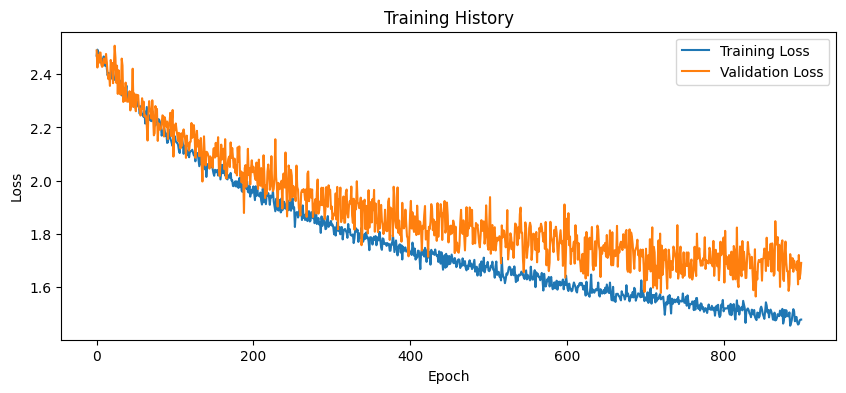

In [27]:
class Attention(nn.Module):
    def __init__(self, emb_size: int, heads: int = 4):
        super().__init__()
        assert emb_size % heads == 0, "emb_size must be divisible by heads"
        self.emb_size = emb_size
        self.heads = heads
        self.head_dim = emb_size // heads

        self.queries = nn.Linear(emb_size, emb_size)
        self.keys    = nn.Linear(emb_size, emb_size)
        self.values  = nn.Linear(emb_size, emb_size)

    def forward(self, x):
        B, L, _ = x.shape                    # (batch, seq_len, emb)
        H, D = self.heads, self.head_dim     # heads, dim per head

        # project and split into heads: (B, H, L, D)
        q = self.queries(x).view(B, L, H, D).transpose(1, 2)
        k = self.keys(x)   .view(B, L, H, D).transpose(1, 2)
        v = self.values(x) .view(B, L, H, D).transpose(1, 2)

        # scaled dot-product attention
        scores = (q @ k.transpose(-2, -1)) / (D ** 0.5)        # (B, H, L, L)
        causal_mask = torch.tril(torch.ones(L, L, device=x.device)).bool()
        scores = scores.masked_fill(~causal_mask, float('-inf'))  # ~ is the not operator (in place of "== 0")
        attn = F.softmax(scores, dim=-1)

        # (B, H, L, D) → (B, L, H, D) → (B, L, E)
        out = (attn @ v).transpose(1, 2).reshape(B, L, self.emb_size)
        return out
    
# Or create model with custom components
model = BaseTransformer(
    vocab_size=vocab_size,
    emb_size=256,
    sequence_length=sequence_length,
    n_blocks=4,
    attention_class=Attention,        # Optional: use your custom attention
    fc_class=None,                      # Optional: use your custom FC
    attention_kwargs={'heads': 4},  # Whatever your attention needs
    fc_kwargs={'hidden_size': 1024, 'n_layers': 2}      # Whatever your FC needs
)

# Train it
history = train_model(
    model, inputs, labels, val_inputs, val_labels, vocab_size,
    epochs=1000, batch_size=1024, device=device
)

# For inference with cached models:
model.reset_cache()  # Reset before inference
model.eval()

generate(model, '\n<mediawiki xmlns="http://www.media', sequence_length, device, texttoint, inttotext, num_tokens=300)

# Plot results

plot_training_history(history)

# Multi Head with cache

Cache size in MB:  4.0
Millions of parameters: 11.43
Epoch ___0 - Loss: 5.890 - Val Loss: 5.529


Epoch _100 - Loss: 2.474 - Val Loss: 2.429
Epoch _200 - Loss: 2.125 - Val Loss: 2.205
Epoch _300 - Loss: 1.949 - Val Loss: 2.056
Epoch _400 - Loss: 1.825 - Val Loss: 1.903
Epoch _500 - Loss: 1.716 - Val Loss: 1.852
Epoch _600 - Loss: 1.635 - Val Loss: 1.755
Epoch _700 - Loss: 1.598 - Val Loss: 1.670
Epoch _800 - Loss: 1.586 - Val Loss: 1.693
Epoch _900 - Loss: 1.517 - Val Loss: 1.730


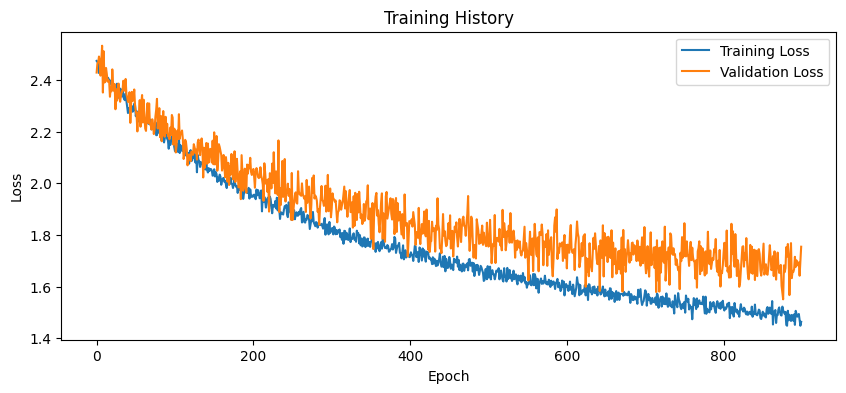

'\n<mediawiki xmlns="http://www.media/m\x122507-07JPG|hinquuspon}}\n| align=&amp;mdash;&amp;mdash;&amp;bull; as hop sprintains on varies deama in the United States]] in the rediece is steighter fift endons to he descriptivist givenery of class with [[Tolyway]] of Western as development of climicing within astroy say deficitly the defeated '

In [28]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, heads, cache_len):
        super().__init__()
        assert emb_size % heads == 0, "emb_size must be divisible by heads"
        self.emb_size  = emb_size
        self.heads = heads
        self.head_dim  = emb_size // heads
        self.scale     = math.sqrt(self.head_dim)
        self.cache_len = cache_len

        self.q_proj = nn.Linear(emb_size, emb_size)
        self.k_proj = nn.Linear(emb_size, emb_size)
        self.v_proj = nn.Linear(emb_size, emb_size)

        self.register_buffer("cache_k", torch.zeros(1, heads, cache_len, self.head_dim))
        self.register_buffer("cache_v", torch.zeros(1, heads, cache_len, self.head_dim))
        self.step = 0

    def _split_heads(self, x):
        B, T, C = x.shape
        return x.view(B, T, self.heads, self.head_dim).transpose(1, 2)

    def _merge_heads(self, x):
        B, H, T, D = x.shape
        return x.transpose(1, 2).contiguous().view(B, T, H * D)

    def forward(self, x, autoregressive=False):
        if autoregressive:
            logits, v = self._update_qkv(x)
        else:
            logits, v = self._compute_qkv(x)
        att = torch.softmax(logits / self.scale, dim=-1)
        out = torch.matmul(att, v)
        return self._merge_heads(out)

    def _compute_qkv(self, x, build_cache=False):
        q = self._split_heads(self.q_proj(x))
        k = self._split_heads(self.k_proj(x))
        v = self._split_heads(self.v_proj(x))

        if build_cache:
            L = x.size(1)
            if L > self.cache_len:
                raise ValueError("sequence length exceeds cache_len")
            self.cache_k[:, :, :L, :] = k
            self.cache_v[:, :, :L, :] = v
            self.step = L

        T = x.size(1)
        mask = torch.tril(torch.ones(T, T, device=x.device, dtype=torch.bool))
        logits = torch.einsum("bhqd,bhkd->bhqk", q, k)
        logits = logits.masked_fill(~mask, float("-inf"))
        return logits, v

    def _update_qkv(self, x):
        assert x.size(0) == 1, "batch size 1 only"
        if self.step == 0:
            return self._compute_qkv(x, build_cache=True)

        q = self._split_heads(self.q_proj(x[:, -1:, :]))
        k = self._split_heads(self.k_proj(x[:, -1:, :]))
        v = self._split_heads(self.v_proj(x[:, -1:, :]))

        if self.step >= self.cache_len:
            raise RuntimeError("KV cache overflow")
        self.cache_k[:, :, self.step:self.step+1, :] = k
        self.cache_v[:, :, self.step:self.step+1, :] = v
        self.step += 1

        logits = torch.einsum("bhqd,bhkd->bhqk", q, self.cache_k[:, :, :self.step, :])
        return logits, self.cache_v[:, :, :self.step, :]


# Or create model with custom components
model = BaseTransformer(
    vocab_size=vocab_size,
    emb_size=256,
    sequence_length=sequence_length,
    n_blocks=4,
    attention_class=MultiHeadAttention,        # Optional: use your custom attention
    fc_class=None,                      # Optional: use your custom FC
    attention_kwargs={'heads': 4, 'cache_len': 2048},  # Whatever your attention needs
    fc_kwargs={'hidden_size': 1024, 'n_layers': 2}      # Whatever your FC needs
)

print("Cache size in MB: ", model.blocks[0].att.cache_k.numel() * 2 * 4 / 1024 / 1024)

# Train it
history = train_model(
    model, inputs, labels, val_inputs, val_labels, vocab_size,
    epochs=1000, batch_size=1024, device=device
)

# Plot results
plot_training_history(history)

# For inference with cached models:
model.reset_cache()  # Reset before inference
model.eval()

generate(model, '\n<mediawiki xmlns="http://www.media', sequence_length, device, texttoint, inttotext, num_tokens=300)


# MLA

Cache size in MB:  0.5
Millions of parameters: 11.69
Epoch ___0 - Loss: 5.937 - Val Loss: 5.666


Epoch _100 - Loss: 2.529 - Val Loss: 2.525
Epoch _200 - Loss: 2.214 - Val Loss: 2.174
Epoch _300 - Loss: 2.026 - Val Loss: 1.996
Epoch _400 - Loss: 1.896 - Val Loss: 1.953
Epoch _500 - Loss: 1.810 - Val Loss: 1.909
Epoch _600 - Loss: 1.733 - Val Loss: 1.809
Epoch _700 - Loss: 1.676 - Val Loss: 1.839
Epoch _800 - Loss: 1.637 - Val Loss: 1.797
Epoch _900 - Loss: 1.595 - Val Loss: 1.672


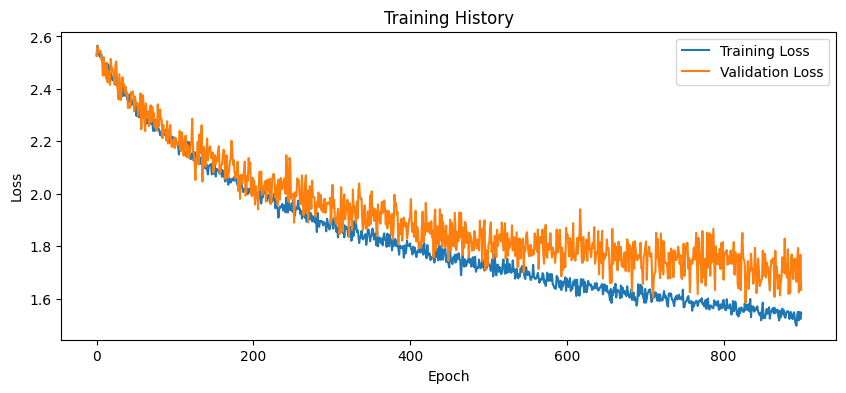

'\n<mediawiki xmlns="http://www.media.wembor  Les of Australia}} [[behaech and were the marsive is close &quot;presseasing frageronization|Lest Mask|Francis | largels = Remarder: Rearden all mocraterity wintings for capposed in the mediy with chapt.&quot; (LD. French Objective field, or and murginght with [[19866]] from [[293th]]\n*[[Ca'

In [29]:
class MultiHeadLatentAttention(nn.Module):
    def __init__(self, emb_size, heads, cache_len):
        super().__init__()
        assert emb_size % heads == 0, "emb_size must be divisible by heads"
        self.emb_size  = emb_size
        self.heads = heads
        self.head_dim  = emb_size // heads
        self.scale     = math.sqrt(self.head_dim)
        self.cache_len = cache_len
        self.cache_dim = 32

        self.q_proj = nn.Linear(emb_size, emb_size)
        self.k_proj = nn.Linear(emb_size, emb_size)
        self.v_proj = nn.Linear(emb_size, emb_size)

        self.down_proj = nn.Linear(emb_size*2, self.cache_dim*2)
        self.up_proj   = nn.Linear(self.cache_dim*2, emb_size*2)
        self.register_buffer("cache_kv", torch.zeros(1, cache_len, self.cache_dim*2))
        self.step = 0

    def _split_heads(self, x):
        B, T, C = x.shape
        return x.view(B, T, self.heads, self.head_dim).transpose(1, 2)

    def _merge_heads(self, x):
        B, H, T, D = x.shape
        return x.transpose(1, 2).contiguous().view(B, T, H * D)

    def _project_kv(self, key, value): # expected (B, H, S, D)
        merged_keys = self._merge_heads(key)
        merged_values = self._merge_heads(value)
        concatenated_kv = torch.cat([merged_keys, merged_values], dim=2)
        return self.down_proj(concatenated_kv)

    def _unproject_kv(self, kv): # expected (B, H, S, D)
        up_projection = self.up_proj(kv)
        key, value = up_projection[:, :, :self.emb_size], up_projection[:, :, self.emb_size:]
        return self._split_heads(key), self._split_heads(value)

    def forward(self, x, autoregressive=False):
        if autoregressive:
            logits, v = self._update_qkv(x)
        else:
            logits, v = self._compute_qkv(x)
        att = torch.softmax(logits / self.scale, dim=-1)
        out = torch.matmul(att, v)
        return self._merge_heads(out)

    def _compute_qkv(self, x, build_cache=False):
        q = self._split_heads(self.q_proj(x))
        k = self._split_heads(self.k_proj(x))
        v = self._split_heads(self.v_proj(x))

        kv = self._project_kv(k, v)

        if build_cache:
            L = x.size(1)
            if L > self.cache_len:
                raise ValueError("sequence length exceeds cache_len")
            self.cache_kv[:, :L, :] = kv
            self.step = L
            k, v = self._unproject_kv(self.cache_kv[:, :L, :])
        else:
            k, v = self._unproject_kv(kv)

        T = x.size(1)
        mask = torch.tril(torch.ones(T, T, device=x.device, dtype=torch.bool))
        logits = torch.einsum("bhqd,bhkd->bhqk", q, k)
        logits = logits.masked_fill(~mask, float("-inf"))
        return logits, v

    def _update_qkv(self, x):
        assert x.size(0) == 1, "batch size 1 only"
        if self.step == 0:
            return self._compute_qkv(x, build_cache=True)

        q = self._split_heads(self.q_proj(x[:, -1:, :]))
        k = self._split_heads(self.k_proj(x[:, -1:, :]))
        v = self._split_heads(self.v_proj(x[:, -1:, :]))

        if self.step >= self.cache_len:
            raise RuntimeError("KV cache overflow")
        self.cache_kv[:, self.step:self.step+1, :] = self._project_kv(k, v)
        self.step += 1

        k, v = self._unproject_kv(self.cache_kv[:, :self.step, :])

        logits = torch.einsum("bhqd,bhkd->bhqk", q, k)
        return logits, v


# Or create model with custom components
model = BaseTransformer(
    vocab_size=vocab_size,
    emb_size=256,
    sequence_length=sequence_length,
    n_blocks=4,
    attention_class=MultiHeadLatentAttention,        # Optional: use your custom attention
    fc_class=None,                      # Optional: use your custom FC
    attention_kwargs={'heads': 4, 'cache_len': 2048},  # Whatever your attention needs
    fc_kwargs={'hidden_size': 1024, 'n_layers': 2}      # Whatever your FC needs
)

print("Cache size in MB: ", model.blocks[0].att.cache_kv.numel() * 4 / 1024 / 1024)

# Train it
history = train_model(
    model, inputs, labels, val_inputs, val_labels, vocab_size,
    epochs=1000, batch_size=1024, device=device
)

# Plot results
plot_training_history(history)

# For inference with cached models:
model.reset_cache()  # Reset before inference
model.eval()

generate(model, '\n<mediawiki xmlns="http://www.media', sequence_length, device, texttoint, inttotext, num_tokens=300)
